In [7]:
import pandas as pd
from sentence_transformers import SentenceTransformer, InputExample, losses, util
from torch.utils.data import DataLoader
import random
from sentence_transformers import util
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
dataset = pd.read_csv("data/processed/eval_dataset.csv").head(1000)

topics = dataset["Topic_group"].unique()
train_examples = [
    InputExample(texts = [row[1]["Document"], row[1]["Topic_group"]], label = 1.0)
    for row in dataset.iterrows()
]

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32, collate_fn=lambda x: x)

In [9]:
model = SentenceTransformer('models/fine_tuned_ticket_embedder')

In [10]:
ft_model = SentenceTransformer('models/fine_tuned_ticket_embedder_v5')


Rapport de classification :
                       precision    recall  f1-score   support

               Access       0.68      0.69      0.68       150
             Hardware       0.59      0.79      0.68       252
        Miscellaneous       0.66      0.47      0.55       171
              Storage       0.65      0.62      0.64        48
           HR Support       0.70      0.74      0.72       240
Administrative rights       1.00      0.14      0.25        42
     Internal Project       0.49      0.42      0.45        45
             Purchase       0.81      0.75      0.78        52

             accuracy                           0.65      1000
            macro avg       0.70      0.58      0.59      1000
         weighted avg       0.67      0.65      0.64      1000



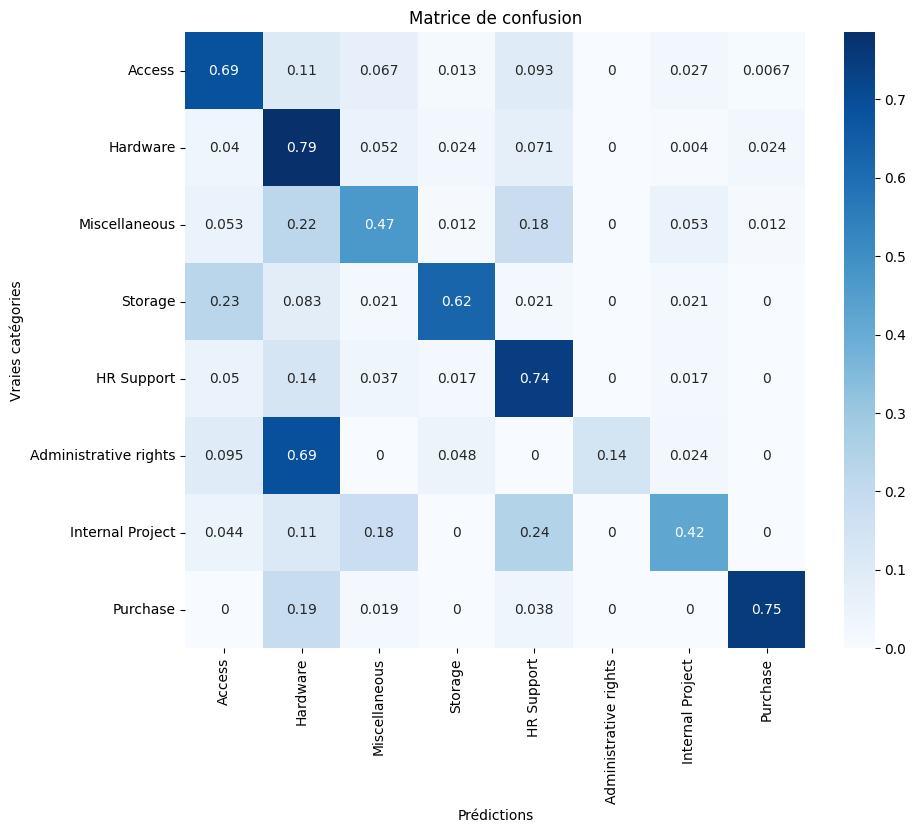

In [11]:
# Liste des catégories (topics)
y_true = []
y_pred = []

# Encoder toutes les catégories une seule fois
emb_topics = model.encode(topics, convert_to_tensor=True)

for batch in train_dataloader:
    tickets = [ex.texts[0] for ex in batch]
    true_categories = [ex.texts[1] for ex in batch]

    # Encoder les tickets en batch
    emb_tickets = model.encode(tickets, convert_to_tensor=True)

    # Similarité tickets vs toutes les catégories
    sims = util.cos_sim(emb_tickets, emb_topics)  # shape: (batch_size, num_topics)

    # Prédiction = catégorie avec la similarité max
    pred_indices = sims.argmax(dim=1).tolist()
    predicted_categories = [topics[i] for i in pred_indices]

    # Stocker les vraies et prédictions
    y_true.extend(true_categories)
    y_pred.extend(predicted_categories)

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred, labels=topics, normalize="true")
report = classification_report(y_true, y_pred, labels=topics)

print("\nRapport de classification :")
print(report)

# Affichage avec Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=topics, yticklabels=topics)
plt.xlabel("Prédictions")
plt.ylabel("Vraies catégories")
plt.title("Matrice de confusion")
plt.show()




Rapport de classification :
                       precision    recall  f1-score   support

               Access       0.82      0.83      0.83       150
             Hardware       0.74      0.78      0.76       252
        Miscellaneous       0.71      0.73      0.72       171
              Storage       0.70      0.90      0.79        48
           HR Support       0.83      0.76      0.79       240
Administrative rights       0.84      0.64      0.73        42
     Internal Project       0.77      0.67      0.71        45
             Purchase       0.74      0.77      0.75        52

             accuracy                           0.77      1000
            macro avg       0.77      0.76      0.76      1000
         weighted avg       0.77      0.77      0.77      1000



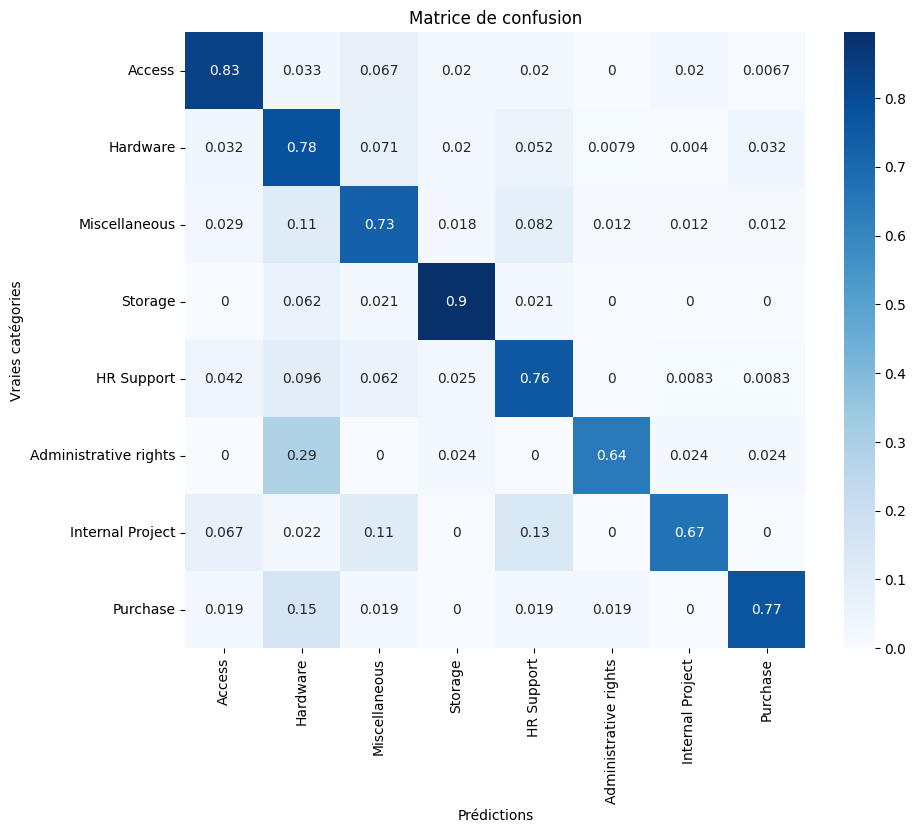

In [12]:
# Liste des catégories (topics)
y_true = []
y_pred = []

# Encoder toutes les catégories une seule fois
emb_topics = ft_model.encode(topics, convert_to_tensor=True)

for batch in train_dataloader:
    tickets = [ex.texts[0] for ex in batch if ex.label == 1.0]
    true_categories = [ex.texts[1] for ex in batch if ex.label == 1.0]

    # Encoder les tickets en batch
    emb_tickets = ft_model.encode(tickets, convert_to_tensor=True)

    # Similarité tickets vs toutes les catégories
    sims = util.cos_sim(emb_tickets, emb_topics)  # shape: (batch_size, num_topics)

    # Prédiction = catégorie avec la similarité max
    pred_indices = sims.argmax(dim=1).tolist()
    predicted_categories = [topics[i] for i in pred_indices]

    # Stocker les vraies et prédictions
    y_true.extend(true_categories)
    y_pred.extend(predicted_categories)

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred, labels=topics, normalize="true")
report = classification_report(y_true, y_pred, labels=topics)

print("\nRapport de classification :")
print(report)

# Affichage avec Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=topics, yticklabels=topics)
plt.xlabel("Prédictions")
plt.ylabel("Vraies catégories")
plt.title("Matrice de confusion")
plt.show()

